In [1]:
import numpy as np
import pandas as pd
import imageio
import h5py
import pickle
import math
import time

from tqdm import tqdm
from xqdm import xqdm
from pathlib import Path
import matplotlib.pyplot as plt
import re

import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [2]:
baseline_model = nn.Sequential(
    nn.Linear(60, 3)
)

In [3]:
summary(baseline_model, (1, 60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 3]             183
Total params: 183
Trainable params: 183
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [4]:
def radian2degree(radian):
    return radian * 180 / math.pi

In [5]:
class BaselineDataset(Dataset):
    def __init__(self, X, Y=None):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        if self.Y is not None:
            y = torch.tensor(self.Y[idx], dtype=torch.float32)
            return x, y
        else:
            return x

In [6]:
num_epochs = 20
batch_size = 64
lr = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.SGD(baseline_model.parameters(), lr=lr)
model = baseline_model.to(device)

In [8]:
with h5py.File('data/head/head-dataset-3166.hdf5', 'r') as f:
    X_train = f['X_train'][()]
    X_valid = f['X_valid'][()]
    Y_train = f['Y_train'][()]
    Y_valid = f['Y_valid'][()]

In [9]:
train_ds = BaselineDataset(X_train, Y_train)
valid_ds = BaselineDataset(X_valid, Y_valid)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [10]:
total_train_losses = []
total_val_losses = []
total_train_yaw = []
total_valid_yaw = []
total_train_pitch = []
total_valid_pitch = []
total_train_roll = []
total_valid_roll = []
total_train_rms = []
total_valid_rms = []
for epoch in range(1, num_epochs + 1):
    # train
    losses = []
    train_diff = []
    model.train()
    with tqdm(total=len(train_dl), desc=f'[{epoch:03d}/{num_epochs:03d}] Train', ncols=100) as t:
        for x, y in train_dl:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            train_mean_loss = sum(losses) / len(losses)
            train_diff.append((y - output).detach())
            t.set_postfix_str(f'loss {train_mean_loss:.4f}', refresh=False)
            t.update()
    total_train_losses.extend(losses)
            
    # valid
    with torch.no_grad():
        losses = []
        valid_diff = []
        model.eval()
        with tqdm(total=len(valid_dl), desc=f'[{epoch:03d}/{num_epochs:03d}] Validation', ncols=100) as t:
            for x, y in valid_dl:
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = criterion(output, y)
                losses.append(loss.item())
                valid_mean_loss = sum(losses) / len(losses)
                valid_diff.append(y - output)
                t.set_postfix_str(f'val_loss {valid_mean_loss:.4f}', refresh=False)
                t.update()
        total_val_losses.extend(losses)
        
        # calculate MAE / RMS
        mae = torch.mean(torch.abs(torch.cat(train_diff)), dim=0)
        mae = radian2degree(mae)
        rms = torch.sqrt(torch.sum(mae) / 3)
        total_train_yaw.append(mae[0].item())
        total_train_pitch.append(mae[1].item())
        total_train_roll.append(mae[2].item())
        total_train_rms.append(rms.item())
        print(f'Train[{epoch:03d}/{num_epochs:03d}]\t' + \
              f'loss {train_mean_loss:.4f}\t' + \
              f'yaw {mae[0].item():.4f}\t' + \
              f'pitch {mae[1].item():.4f}\t' + \
              f'roll {mae[2].item():.4f}\t' + \
              f'rms: {rms.item():.4f}')
        
        mae = torch.mean(torch.abs(torch.cat(valid_diff)), dim=0)
        mae = radian2degree(mae)
        rms = torch.sqrt(torch.sum(mae) / 3)
        total_valid_yaw.append(mae[0].item())
        total_valid_pitch.append(mae[1].item())
        total_valid_roll.append(mae[2].item())
        total_valid_rms.append(rms.item())
        print(f'Valid[{epoch:03d}/{num_epochs:03d}]\t' + \
              f'val_loss {valid_mean_loss:.4f}\t' + \
              f'yaw {mae[0].item():.4f}\t' + \
              f'pitch {mae[1].item():.4f}\t' + \
              f'roll {mae[2].item():.4f}\t' + \
              f'rms: {rms.item():.4f}')
        time.sleep(0.2)

[001/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1137.69it/s, val_loss 0.0252]


Train[001/020]	loss 0.0283	yaw 9.5564	pitch 2.5814	roll 3.4181	rms: 2.2771
Valid[001/020]	val_loss 0.0252	yaw 9.0090	pitch 2.4168	roll 6.8599	rms: 2.4689


[002/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1147.83it/s, val_loss 0.0134]


Train[002/020]	loss 0.0089	yaw 5.0863	pitch 2.0380	roll 2.1900	rms: 1.7620
Valid[002/020]	val_loss 0.0134	yaw 5.1836	pitch 2.2107	roll 5.4833	rms: 2.0718


[003/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1154.16it/s, val_loss 0.0095]


Train[003/020]	loss 0.0056	yaw 3.6495	pitch 1.8806	roll 1.8448	rms: 1.5679
Valid[003/020]	val_loss 0.0095	yaw 3.7873	pitch 2.0760	roll 4.7268	rms: 1.8788


[004/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1189.09it/s, val_loss 0.0075]


Train[004/020]	loss 0.0046	yaw 3.1256	pitch 1.7650	roll 1.6884	rms: 1.4809
Valid[004/020]	val_loss 0.0075	yaw 3.2917	pitch 1.9801	roll 4.2071	rms: 1.7775


[005/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1190.06it/s, val_loss 0.0062]


Train[005/020]	loss 0.0040	yaw 2.9130	pitch 1.6766	roll 1.5975	rms: 1.4361
Valid[005/020]	val_loss 0.0062	yaw 3.0835	pitch 1.9080	roll 3.7977	rms: 1.7116


[006/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1166.90it/s, val_loss 0.0054]


Train[006/020]	loss 0.0037	yaw 2.7883	pitch 1.6078	roll 1.5330	rms: 1.4058
Valid[006/020]	val_loss 0.0054	yaw 2.9704	pitch 1.8524	roll 3.4560	rms: 1.6612


[007/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1108.24it/s, val_loss 0.0047]


Train[007/020]	loss 0.0034	yaw 2.6951	pitch 1.5536	roll 1.4822	rms: 1.3821
Valid[007/020]	val_loss 0.0047	yaw 2.8976	pitch 1.8085	roll 3.1648	rms: 1.6198


[008/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1164.22it/s, val_loss 0.0042]


Train[008/020]	loss 0.0032	yaw 2.6197	pitch 1.5105	roll 1.4401	rms: 1.3626
Valid[008/020]	val_loss 0.0042	yaw 2.8465	pitch 1.7734	roll 2.9149	rms: 1.5848


[009/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1173.85it/s, val_loss 0.0038]


Train[009/020]	loss 0.0031	yaw 2.5567	pitch 1.4756	roll 1.4042	rms: 1.3462
Valid[009/020]	val_loss 0.0038	yaw 2.8087	pitch 1.7450	roll 2.6991	rms: 1.5549


[010/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1170.37it/s, val_loss 0.0036]


Train[010/020]	loss 0.0030	yaw 2.5034	pitch 1.4468	roll 1.3730	rms: 1.3321
Valid[010/020]	val_loss 0.0036	yaw 2.7789	pitch 1.7216	roll 2.5125	rms: 1.5289


[011/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1166.94it/s, val_loss 0.0033]


Train[011/020]	loss 0.0029	yaw 2.4575	pitch 1.4224	roll 1.3453	rms: 1.3198
Valid[011/020]	val_loss 0.0033	yaw 2.7541	pitch 1.7021	roll 2.3510	rms: 1.5063


[012/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1193.04it/s, val_loss 0.0031]


Train[012/020]	loss 0.0028	yaw 2.4176	pitch 1.4017	roll 1.3205	rms: 1.3089
Valid[012/020]	val_loss 0.0031	yaw 2.7328	pitch 1.6855	roll 2.2120	rms: 1.4866


[013/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1136.25it/s, val_loss 0.0030]


Train[013/020]	loss 0.0027	yaw 2.3827	pitch 1.3837	roll 1.2980	rms: 1.2993
Valid[013/020]	val_loss 0.0030	yaw 2.7137	pitch 1.6712	roll 2.0931	rms: 1.4695


[014/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1166.72it/s, val_loss 0.0029]


Train[014/020]	loss 0.0026	yaw 2.3519	pitch 1.3678	roll 1.2774	rms: 1.2906
Valid[014/020]	val_loss 0.0029	yaw 2.6964	pitch 1.6588	roll 1.9919	rms: 1.4545


[015/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1132.03it/s, val_loss 0.0028]


Train[015/020]	loss 0.0026	yaw 2.3245	pitch 1.3536	roll 1.2585	rms: 1.2828
Valid[015/020]	val_loss 0.0028	yaw 2.6806	pitch 1.6478	roll 1.9063	rms: 1.4416


[016/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1152.10it/s, val_loss 0.0027]


Train[016/020]	loss 0.0025	yaw 2.3000	pitch 1.3407	roll 1.2410	rms: 1.2756
Valid[016/020]	val_loss 0.0027	yaw 2.6659	pitch 1.6381	roll 1.8340	rms: 1.4304


[017/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1148.63it/s, val_loss 0.0027]


Train[017/020]	loss 0.0025	yaw 2.2778	pitch 1.3289	roll 1.2246	rms: 1.2690
Valid[017/020]	val_loss 0.0027	yaw 2.6521	pitch 1.6292	roll 1.7730	rms: 1.4206


[018/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1159.67it/s, val_loss 0.0026]


Train[018/020]	loss 0.0025	yaw 2.2577	pitch 1.3180	roll 1.2093	rms: 1.2629
Valid[018/020]	val_loss 0.0026	yaw 2.6391	pitch 1.6211	roll 1.7216	rms: 1.4121


[019/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1158.21it/s, val_loss 0.0025]


Train[019/020]	loss 0.0024	yaw 2.2394	pitch 1.3079	roll 1.1949	rms: 1.2573
Valid[019/020]	val_loss 0.0025	yaw 2.6267	pitch 1.6136	roll 1.6781	rms: 1.4046


[020/020] Validation: 100%|██████████████████| 2746/2746 [00:02<00:00, 1134.74it/s, val_loss 0.0025]


Train[020/020]	loss 0.0024	yaw 2.2225	pitch 1.2985	roll 1.1812	rms: 1.2520
Valid[020/020]	val_loss 0.0025	yaw 2.6149	pitch 1.6066	roll 1.6414	rms: 1.3980


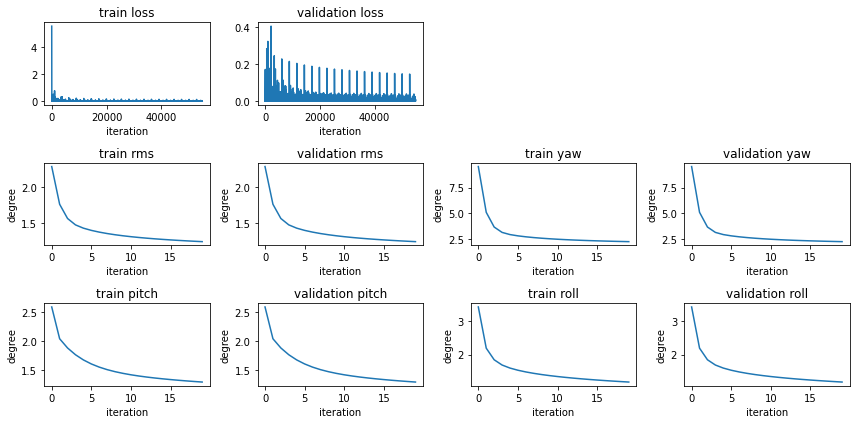

In [11]:
R, C = 3, 4
plt.figure(figsize=(12, 6))

plt.subplot(R, C, 1)
plt.plot(total_train_losses)
plt.title('train loss')
plt.xlabel('iteration')
plt.subplot(R, C, 2)
plt.plot(total_val_losses)
plt.title('validation loss')
plt.xlabel('iteration')

plt.subplot(R, C, 5)
plt.plot(total_train_rms)
plt.title('train rms')
plt.ylabel('degree')
plt.xlabel('iteration')
plt.subplot(R, C, 6)
plt.plot(total_train_rms)
plt.title('validation rms')
plt.ylabel('degree')
plt.xlabel('iteration')

plt.subplot(R, C, 7)
plt.plot(total_train_yaw)
plt.title('train yaw')
plt.ylabel('degree')
plt.xlabel('iteration')
plt.subplot(R, C, 8)
plt.plot(total_train_yaw)
plt.title('validation yaw')
plt.ylabel('degree')
plt.xlabel('iteration')

plt.subplot(R, C, 9)
plt.plot(total_train_pitch)
plt.title('train pitch')
plt.ylabel('degree')
plt.xlabel('iteration')
plt.subplot(R, C, 10)
plt.plot(total_train_pitch)
plt.title('validation pitch')
plt.ylabel('degree')
plt.xlabel('iteration')

plt.subplot(R, C, 11)
plt.plot(total_train_roll)
plt.title('train roll')
plt.ylabel('degree')
plt.xlabel('iteration')
plt.subplot(R, C, 12)
plt.plot(total_train_roll)
plt.title('validation roll')
plt.ylabel('degree')
plt.xlabel('iteration')

plt.tight_layout()
plt.show()